# MTA Turnstile Data Analysis: Benford's Law

Does MTA Turnstile Data follow [Benford's Law](https://en.wikipedia.org/wiki/Benford%27s_law)? 


### Distribution of leading digits according to Benford's Law

In [1]:
import datetime
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
benfords = pd.DataFrame({'digit': list(range(1, 10)), 
                       'percent': [30.1, 17.6, 12.5, 9.7, 7.9, 6.7, 5.8, 5.1, 4.6]}, 
                       index=list(range(1, 10)))
benfords

,digit,percent
1,1,30.1
2,2,17.6
3,3,12.5
4,4,9.7
5,5,7.9
6,6,6.7
7,7,5.8
8,8,5.1
9,9,4.6


### MTA Turnstile Data

- [MTA Turnstile Data](http://web.mta.info/developers/turnstile.html)
- [MTA Turnstile Data - Codebook](http://web.mta.info/developers/resources/nyct/turnstile/ts_Field_Description.txt)
- [Kaggle: MTA Turnstile Data Analysis](https://www.kaggle.com/nieyuqi/mta-turnstile-data-analysis)

## Data Import and Scrubing

In [3]:
def get_data(week_nums):
    url = "http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt"
    dfs = []
    for week_num in week_nums:
        file_url = url.format(week_num)
        dfs.append(pd.read_csv(file_url))
    return pd.concat(dfs)

In [4]:
# Grab last 4 weeks of data: 
import_weeks = [200926, 200919, 200912, 200905]

mta_raw = get_data(import_weeks)

In [5]:
mta_raw.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,00:00:00,REGULAR,7460236,2537220
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,04:00:00,REGULAR,7460241,2537220
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,08:00:00,REGULAR,7460260,2537239
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,12:00:00,REGULAR,7460289,2537289
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/19/2020,16:00:00,REGULAR,7460377,2537315


### Formatting New and Existing Columns

In [6]:
# Rename columns for easier coding later

mta_raw.columns = ['ca',
                   'unit',
                  'scp',
                  'station',
                  'linename',
                  'division',
                  'date',
                  'time',
                  'desc',
                  'entries_cum',
                  'exits_cum']

In [7]:
# Create a timestamp column with datetime object
# Convert date data to datetime object

mta_raw['timestamp'] = pd.to_datetime(mta_raw['date'] + ' ' + mta_raw['time'])
mta_raw['date'] = pd.to_datetime(mta_raw['date'])

In [8]:
# Create turnstile column as proxy for unique identifier
mta_raw['turnstile'] = mta_raw['station'] + '-' + mta_raw['ca'] + '-' + mta_raw['unit'] + '-' + mta_raw['scp']

### Checking for Duplicates

In [9]:
# Checking for duplicates
dupes = mta_raw.groupby(['turnstile', 'timestamp'])['entries_cum'].count().reset_index().sort_values('entries_cum', ascending=False)

In [10]:
dupes = dupes[dupes['entries_cum'] > 1]
print('# of Duplicate Entries: {}'.format(len(dupes)))
dupes

# of Duplicate Entries: 15


,turnstile,timestamp,entries_cum
241767,59 ST-R245A-R051-01-00-00,2020-09-12 00:00:00,2
87080,181 ST-N007A-R174-00-00-00,2020-09-23 13:00:00,2
370702,BERGEN ST-N532-R129-00-00-00,2020-08-31 17:00:00,2
290519,86 ST-2 AVE-N701-R571-00-00-00,2020-09-24 09:00:00,2
778210,SUTTER AV-RUTLD-R627-R063-00-00-00,2020-09-07 16:00:00,2
87248,181 ST-N007A-R174-00-00-01,2020-09-23 13:00:00,2
778212,SUTTER AV-RUTLD-R627-R063-00-00-00,2020-09-08 00:00:00,2
778380,SUTTER AV-RUTLD-R627-R063-00-00-01,2020-09-08 00:00:00,2
778378,SUTTER AV-RUTLD-R627-R063-00-00-01,2020-09-07 16:00:00,2
233753,59 ST-A002-R051-02-00-00,2020-09-12 12:00:00,2


In [11]:
mta_raw.desc.value_counts()

REGULAR       834643
RECOVR AUD      3484
Name: desc, dtype: int64

In [12]:
mta_raw[(mta_raw['turnstile']=='59 ST-R245A-R051-01-00-00') &
       (mta_raw['timestamp']=='2020-09-12 00:00:00')]

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile
166509,R245A,R051,01-00-00,59 ST,456NQRW,IRT,2020-09-12,00:00:00,REGULAR,13703909,4892239,2020-09-12,59 ST-R245A-R051-01-00-00
166510,R245A,R051,01-00-00,59 ST,456NQRW,IRT,2020-09-12,00:00:00,RECOVR AUD,26726,3996,2020-09-12,59 ST-R245A-R051-01-00-00


In [13]:
mta_raw[(mta_raw['turnstile']=='181 ST-N007A-R174-00-00-00') &
       (mta_raw['timestamp']=='2020-09-23 13:00:00')]

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile
46407,N007A,R174,00-00-00,181 ST,A,IND,2020-09-23,13:00:00,REGULAR,4,0,2020-09-23 13:00:00,181 ST-N007A-R174-00-00-00
46408,N007A,R174,00-00-00,181 ST,A,IND,2020-09-23,13:00:00,RECOVR AUD,10732094,11586103,2020-09-23 13:00:00,181 ST-N007A-R174-00-00-00


### Calculating actual entries & exits from cumulative figures

In [14]:
mta_sorted = mta_raw.sort_values(['turnstile', 'timestamp'])
mta_sorted = mta_sorted.reset_index(drop = True)

turnstile_grouped = mta_sorted.groupby(['turnstile'])

mta_sorted['entries'] = turnstile_grouped['entries_cum'].transform(pd.Series.diff).abs()
mta_sorted['exits'] = turnstile_grouped['exits_cum'].transform(pd.Series.diff).abs()

In [15]:
mta_sorted.head(3)

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile,entries,exits
0,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,00:00:00,REGULAR,15470879,17378563,2020-08-29 00:00:00,1 AV-H007-R248-00-00-00,NaN,NaN
1,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,04:00:00,RECOVR AUD,15470881,17378580,2020-08-29 04:00:00,1 AV-H007-R248-00-00-00,2.0,17.0
2,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,08:00:00,REGULAR,15470894,17378700,2020-08-29 08:00:00,1 AV-H007-R248-00-00-00,13.0,120.0


### Dealing with outliers & NaN values

In [16]:
print('Number of negative entries: %d' %len(mta_sorted['entries'][mta_sorted['entries'] < 0]))
print('Number of negative exits: %d' %len(mta_sorted['exits'][mta_sorted['exits'] < 0]))
print('')
print('Number of entries > 10k: %d' %len(mta_sorted['entries'][mta_sorted['entries'] > 10000]))
print('Number of exits > 10k: %d' %len(mta_sorted['exits'][mta_sorted['exits'] > 10000]))
print('')
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries'].isnull()]))

Number of negative entries: 0
Number of negative exits: 0

Number of entries > 10k: 157
Number of exits > 10k: 148

Number of NaN rows: 4981


In [17]:
# Filtering for values above our 10k threshold

ents_10k = mta_sorted.loc[:, 'entries'] > 10000
exits_10k = mta_sorted.loc[:, 'exits'] > 10000

In [18]:
# Converting negative and above threshold entries to Nan

mta_sorted.loc[ents_10k, 'entries'] = np.nan
mta_sorted.loc[exits_10k, 'exits'] = np.nan

In [19]:
print('Number of negative entries: %d' %len(mta_sorted['entries'][mta_sorted['entries'] < 0]))
print('Number of negative exits: %d' %len(mta_sorted['exits'][mta_sorted['exits'] < 0]))
print('')
print('Number of entries > 10k: %d' %len(mta_sorted['entries'][mta_sorted['entries'] > 10000]))
print('Number of exits > 10k: %d' %len(mta_sorted['exits'][mta_sorted['exits'] > 10000]))
print('')
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries'].isnull()]))

Number of negative entries: 0
Number of negative exits: 0

Number of entries > 10k: 0
Number of exits > 10k: 0

Number of NaN rows: 5138


In [20]:
# Dropping na values

mta_sorted.dropna(inplace=True)

In [21]:
print('Number of NaN rows: %d' %len(mta_sorted[mta_sorted['entries'].isnull()]))

Number of NaN rows: 0


In [22]:
mta_sorted['total'] = mta_sorted['entries'] + mta_sorted['exits']

In [23]:
mta_sorted['weekday'] = mta_sorted['date'].dt.day_name()
mta_sorted['weekday_num'] = mta_sorted['date'].dt.dayofweek

In [24]:
mta_sorted.head(3)

,ca,unit,scp,station,linename,division,date,time,desc,entries_cum,exits_cum,timestamp,turnstile,entries,exits,total,weekday,weekday_num
1,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,04:00:00,RECOVR AUD,15470881,17378580,2020-08-29 04:00:00,1 AV-H007-R248-00-00-00,2.0,17.0,19.0,Saturday,5
2,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,08:00:00,REGULAR,15470894,17378700,2020-08-29 08:00:00,1 AV-H007-R248-00-00-00,13.0,120.0,133.0,Saturday,5
3,H007,R248,00-00-00,1 AV,L,BMT,2020-08-29,12:00:00,REGULAR,15470949,17378915,2020-08-29 12:00:00,1 AV-H007-R248-00-00-00,55.0,215.0,270.0,Saturday,5


### Final clean MTA dataframe

In [25]:
mta = mta_sorted[['station', 
                 'ca', 
                 'unit',
                 'scp',
                 'linename',
                 'division',
                 'date',
                 'time',
                 'timestamp',
                 'weekday',
                 'weekday_num',
                 'entries',
                 'exits',
                 'total']]

In [26]:
mta.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total
1,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,2.0,17.0,19.0
2,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,13.0,120.0,133.0
3,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,55.0,215.0,270.0


In [27]:
del mta_raw
del mta_sorted

## Setting up `MTA` for Benford's Testing

In [28]:
mta['ent_dig'] = mta['entries'].astype(str)
mta['ent_dig'] = (mta['ent_dig'].apply(lambda x: x[0])).astype(int)

mta['ex_dig'] = mta['exits'].astype(str)
mta['ex_dig'] = (mta['ex_dig'].apply(lambda x: x[0])).astype(int)

mta['total_dig'] = mta['total'].astype(str)
mta['total_dig'] = (mta['total_dig'].apply(lambda x: x[0])).astype(int)

<ipython-input-28-cc484278e462>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta['ent_dig'] = mta['entries'].astype(str)
<ipython-input-28-cc484278e462>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mta['ent_dig'] = (mta['ent_dig'].apply(lambda x: x[0])).astype(int)
<ipython-input-28-cc484278e462>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

In [29]:
mta.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
1,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,2.0,17.0,19.0,2,1,1
2,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,13.0,120.0,133.0,1,1,1
3,1 AV,H007,R248,00-00-00,L,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,55.0,215.0,270.0,5,2,2


In [30]:
ent_zeroes = mta[mta['ent_dig']==0]
ent_zeroes.head(3)

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
19,1 AV,H007,R248,00-00-00,L,BMT,2020-09-01,04:00:00,2020-09-01 04:00:00,Tuesday,1,0.0,9.0,9.0,0,9,9
25,1 AV,H007,R248,00-00-00,L,BMT,2020-09-02,04:00:00,2020-09-02 04:00:00,Wednesday,2,0.0,9.0,9.0,0,9,9
31,1 AV,H007,R248,00-00-00,L,BMT,2020-09-03,04:00:00,2020-09-03 04:00:00,Thursday,3,0.0,15.0,15.0,0,1,1


In [31]:
exit_zeroes = mta[mta['ex_dig']==0]
total_zeroes = mta[mta['total_dig']==0]

print('Number of Entry Zeroes: {}'.format(len(ent_zeroes)))
print('Number of Exit Zeroes: {}'.format(len(exit_zeroes)))
print('Number of Total Zeroes: {}'.format(len(total_zeroes)))

Number of Entry Zeroes: 193429
Number of Exit Zeroes: 156409
Number of Total Zeroes: 130587


### Dealing with Zeros

As shown above, there are thousands of entries with a zero as the leading digit for entries, extits, and/or total. 

**Next steps**
* Split up `mta` into three dataframes focusing on leading digits: 
    * Entries
    * Exits
    * Total
* Drop rows with zeroes from these dataframes  

In [32]:
benford_ents = mta[mta['ent_dig'] > 0]
benford_exits = mta[mta['ex_dig'] > 0]
benford_total = mta[mta['total_dig'] > 0]

## Benford's Law Test: Entries

### Setting up the Entries DataFrame

In [33]:
benford_ents = benford_ents[['station', 'date', 'time', 'timestamp', 'weekday', 'weekday_num', 'ent_dig']]
benford_ents.head(3)

,station,date,time,timestamp,weekday,weekday_num,ent_dig
1,1 AV,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,2
2,1 AV,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,1
3,1 AV,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,5


In [34]:
nums = list(range(1, 10))
benford_ents_count = list(benford_ents.ent_dig.value_counts())
benford_ents_df = pd.DataFrame({'digit': nums, 
                              'counts': benford_ents_count}, index=nums)
benford_ents_df

,digit,counts
1,1,207146
2,2,113084
3,3,76387
4,4,59372
5,5,48314
6,6,41203
7,7,35586
8,8,30965
9,9,27500


In [35]:
total_entries = benford_ents_df.counts.sum()
total_entries

639557

In [36]:
# Creating % Frequency Column
benford_ents_df['percent'] = benford_ents_df['counts'].apply(lambda x: (x / total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
benford_ents_df['benfords'] = benfords['percent']
benford_ents_df['diff_abs'] = (benford_ents_df['percent'] - benford_ents_df['benfords']).abs()
benford_ents_df['diff_perc'] = (benford_ents_df['diff_abs'] / benford_ents_df['percent']) * 100

In [37]:
benford_ents_df

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,207146,32.4,30.1,2.3,7.098765
2,2,113084,17.7,17.6,0.1,0.564972
3,3,76387,11.9,12.5,0.6,5.042017
4,4,59372,9.3,9.7,0.4,4.301075
5,5,48314,7.6,7.9,0.3,3.947368
6,6,41203,6.4,6.7,0.3,4.687500
7,7,35586,5.6,5.8,0.2,3.571429
8,8,30965,4.8,5.1,0.3,6.250000
9,9,27500,4.3,4.6,0.3,6.976744


### Plotting Entries Results

[Matplotlib: Grouped bar chart with labels](https://matplotlib.org/3.1.0/gallery/lines_bars_and_markers/barchart.html)

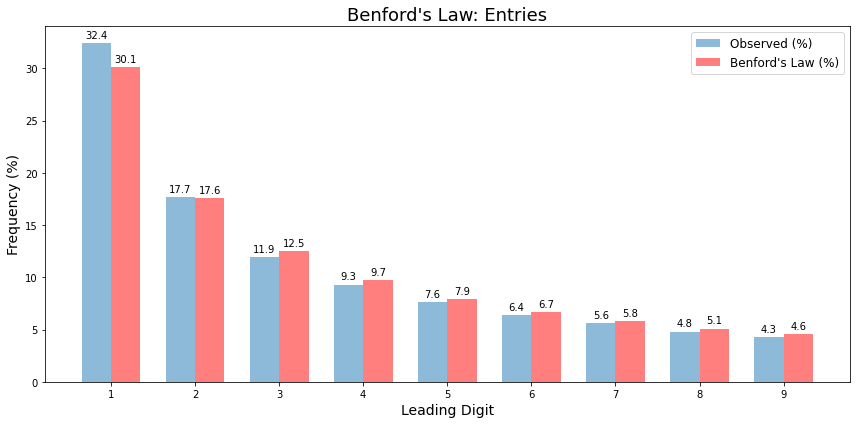

In [38]:
labels = list(range(1, 10))
observed = benford_ents_df['percent']
benford_percents = benford_ents_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Entries", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show();

## Benford's Law Test: Exits

### Setting up the Exits DataFrame

In [39]:
benford_exits = benford_exits[['station', 'date', 'time', 'timestamp', 'weekday', 'weekday_num', 'ex_dig']]
benford_exits.head(3)

,station,date,time,timestamp,weekday,weekday_num,ex_dig
1,1 AV,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,1
2,1 AV,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,1
3,1 AV,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,2


In [40]:
nums = list(range(1, 10))
benford_exits_count = list(benford_exits.ex_dig.value_counts())
benford_exits_df = pd.DataFrame({'digit': nums, 
                              'counts': benford_exits_count}, index=nums)
benford_exits_df

,digit,counts
1,1,212253
2,2,119059
3,3,84402
4,4,64321
5,5,52462
6,6,44039
7,7,37653
8,8,33093
9,9,29295


In [41]:
total_exits = benford_exits_df.counts.sum()
total_exits

676577

In [42]:
# Creating % Frequency Column
benford_exits_df['percent'] = benford_exits_df['counts'].apply(lambda x: (x / total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
benford_exits_df['benfords'] = benfords['percent']
benford_exits_df['diff_abs'] = (benford_exits_df['percent'] - benford_exits_df['benfords']).abs()
benford_exits_df['diff_perc'] = (benford_exits_df['diff_abs'] / benford_exits_df['percent']) * 100

In [43]:
benford_exits_df

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,212253,33.2,30.1,3.1,9.337349
2,2,119059,18.6,17.6,1.0,5.376344
3,3,84402,13.2,12.5,0.7,5.303030
4,4,64321,10.1,9.7,0.4,3.960396
5,5,52462,8.2,7.9,0.3,3.658537
6,6,44039,6.9,6.7,0.2,2.898551
7,7,37653,5.9,5.8,0.1,1.694915
8,8,33093,5.2,5.1,0.1,1.923077
9,9,29295,4.6,4.6,0.0,0.000000


### Plotting Exits Results

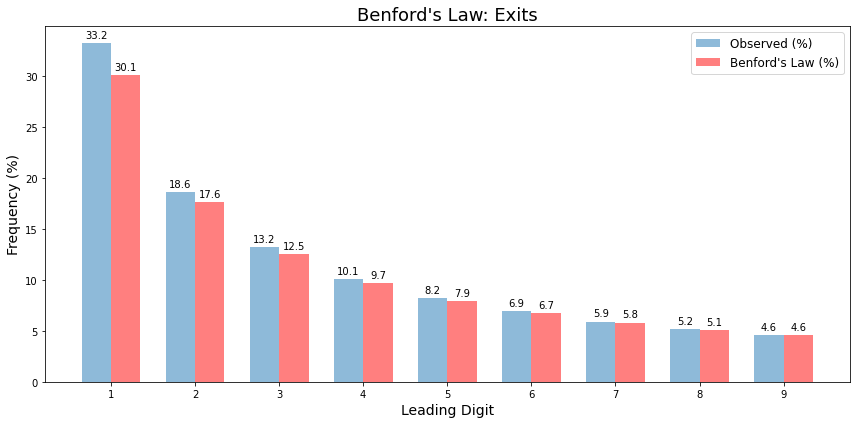

In [44]:
labels = list(range(1, 10))
observed = benford_exits_df['percent']
benford_percents = benford_exits_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Exits", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show();

## Benford's Law Test: Total

### Setting up the Total DataFrame

In [45]:
benford_total = benford_total[['station', 'date', 'time', 'timestamp', 'weekday', 'weekday_num', 'total_dig']]
benford_total.head(3)

,station,date,time,timestamp,weekday,weekday_num,total_dig
1,1 AV,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,1
2,1 AV,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,1
3,1 AV,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,2


In [46]:
nums = list(range(1, 10))
benford_total_count = list(benford_total.total_dig.value_counts())
benford_total_df = pd.DataFrame({'digit': nums, 
                              'counts': benford_total_count}, index=nums)
benford_total_df

,digit,counts
1,1,229298
2,2,129446
3,3,85001
4,4,62491
5,5,50722
6,6,42950
7,7,37620
8,8,33791
9,9,31080


In [47]:
total_total = benford_total_df.counts.sum()
total_total

702399

In [48]:
# Creating % Frequency Column
benford_total_df['percent'] = benford_total_df['counts'].apply(lambda x: (x / total_entries) * 100).round(decimals=1)

# Adding Benford's Law %s, and some calculation columns to see the difference
benford_total_df['benfords'] = benfords['percent']
benford_total_df['diff_abs'] = (benford_total_df['percent'] - benford_total_df['benfords']).abs()
benford_total_df['diff_perc'] = (benford_total_df['diff_abs'] / benford_total_df['percent']) * 100

In [49]:
benford_total_df

,digit,counts,percent,benfords,diff_abs,diff_perc
1,1,229298,35.9,30.1,5.8,16.155989
2,2,129446,20.2,17.6,2.6,12.871287
3,3,85001,13.3,12.5,0.8,6.015038
4,4,62491,9.8,9.7,0.1,1.020408
5,5,50722,7.9,7.9,0.0,0.000000
6,6,42950,6.7,6.7,0.0,0.000000
7,7,37620,5.9,5.8,0.1,1.694915
8,8,33791,5.3,5.1,0.2,3.773585
9,9,31080,4.9,4.6,0.3,6.122449


### Plotting the Results

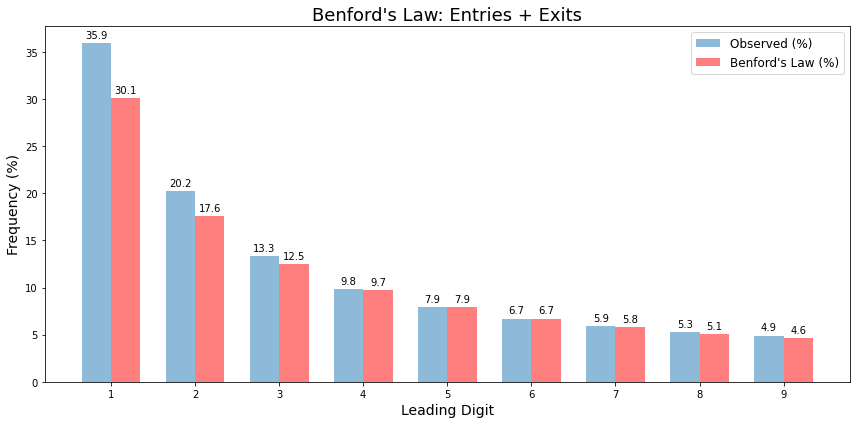

In [50]:
labels = list(range(1, 10))
observed = benford_total_df['percent']
benford_percents = benford_total_df['benfords']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - width/2, observed, width, label='Observed (%)', alpha=0.5)
rects2 = ax.bar(x + width/2, benford_percents, width, label="Benford's Law (%)", color='red', alpha=0.5)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Frequency (%)', fontsize=14)
ax.set_xlabel('Leading Digit', fontsize=14)
ax.set_title("Benford's Law: Entries + Exits", fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(fontsize=12)


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show();

## Comparison

Create a dataframe for comparing entries, exits, and total -- which follows best? 

Also maybe try it out on a couple different stations: Time Square, versus Prospect Park? 

In [59]:
timesquare = mta[(mta['ent_dig'] > 0) & 
                 (mta['station'] == 'TIMES SQ-42 ST')]
timesquare.head()

,station,ca,unit,scp,linename,division,date,time,timestamp,weekday,weekday_num,entries,exits,total,ent_dig,ex_dig,total_dig
784858,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,04:00:00,2020-08-29 04:00:00,Saturday,5,6.0,10.0,16.0,6,1,1
784859,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,08:00:00,2020-08-29 08:00:00,Saturday,5,18.0,58.0,76.0,1,5,7
784860,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,12:00:00,2020-08-29 12:00:00,Saturday,5,61.0,166.0,227.0,6,1,2
784861,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,16:00:00,2020-08-29 16:00:00,Saturday,5,84.0,176.0,260.0,8,1,2
784862,TIMES SQ-42 ST,A021,R032,01-00-00,ACENQRS1237W,BMT,2020-08-29,20:00:00,2020-08-29 20:00:00,Saturday,5,132.0,132.0,264.0,1,1,2


In [61]:
timesquare = timesquare[['date', 'timestamp', 'weekday_num', 'ent_dig']]
timesquare.head()

,date,timestamp,weekday_num,ent_dig
784858,2020-08-29,2020-08-29 04:00:00,5,6
784859,2020-08-29,2020-08-29 08:00:00,5,1
784860,2020-08-29,2020-08-29 12:00:00,5,6
784861,2020-08-29,2020-08-29 16:00:00,5,8
784862,2020-08-29,2020-08-29 20:00:00,5,1


In [62]:
nums = list(range(1, 10))
timesquare_ent_count = list(benford_total.total_dig.value_counts())
timesquare_benfords = pd.DataFrame({'digit': nums, 
                              'counts': timesquare_ent_count}, index=nums)
timesquare_benfords

,digit,counts
1,1,229298
2,2,129446
3,3,85001
4,4,62491
5,5,50722
6,6,42950
7,7,37620
8,8,33791
9,9,31080
